# StockExplorer PixieApp Part 2 - Time Series Forecasting with ARIMA model
## We start by installing quandl and statsmodels library if necessary

In [ ]:
# !pip install quandl

In [98]:
# !pip install statsmodels

## Import a few modules and optionally set the quandl API key

In [1]:
import pixiedust
from pixiedust.display.app import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl

#Comment the line below if you don't have a Quandl API Key
#To get an API key, go to https://www.quandl.com
quandl.ApiConfig.api_key = "XXXX"

Pixiedust database opened successfully


## Download the list of database codes and display it using PixieDust display()

## Download the stock data for MSFT and display a bokeh line chart of the Time Serie

In [2]:
msft = quandl.get('WIKI/MSFT')
msft['daily_spread'] = msft['Adj. Close'].diff()
msft = msft.reset_index()

In [3]:
display(msft)

## Test for stationarity

In [ ]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
series = msft['Adj. Close']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
result = adfuller(np.log(X))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

## Build an ARIMA model

In [3]:
train_set, test_set = msft[:-14], msft[-14:]

In [4]:
logmsft = np.log(train_set['Adj. Close'])
logmsft.index = train_set['Date']
logmsft_diff = pd.DataFrame(logmsft - logmsft.shift()).reset_index()
logmsft_diff.dropna(inplace=True)
display(logmsft_diff)

## Apply the Dickey-Fuller test

In [219]:
from statsmodels.tsa.stattools import adfuller
import pprint

ad_fuller_results = adfuller(
    logmsft_diff['Adj. Close'], autolag = 'AIC', regression = 'c')
labels = ['Test Statistic','MacKinnon’s approximate p-value','Number of lags used','Number of Observations Used']
pp = pprint.PrettyPrinter(indent=4)
pp.pprint({labels[i]: ad_fuller_results[i] for i in range(4)})

{   'MacKinnon’s approximate p-value': 0.0,
    'Number of Observations Used': 8057,
    'Number of lags used': 3,
    'Test Statistic': -48.071592138591136}


## Plot the ACF chart

In [ ]:
import statsmodels.tsa.api as smt
smt.graphics.plot_acf(logmsft_diff['Adj. Close'], lags=100)
plt.show()

## Plot the PACF chart

In [ ]:
smt.graphics.plot_pacf(logmsft_diff['Adj. Close'], lags=100)
plt.show()

## Create the ARIMA model and returned details about the residual errors

In [4]:
from statsmodels.tsa.arima_model import ARIMA

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    arima_model_class = ARIMA(train_set['Adj. Close'], dates=train_set['Date'], order=(1,1,1))
    arima_model = arima_model_class.fit(disp=0)

    print(arima_model.resid.describe())

/Users/dtaieb/anaconda/envs/dashboard/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/dtaieb/anaconda/envs/dashboard/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


count    8.061000e+03
mean    -5.785533e-07
std      4.198119e-01
min     -5.118915e+00
25%     -1.061133e-01
50%     -1.184452e-02
75%      9.848486e-02
max      5.023380e+00
dtype: float64


In [5]:
s = arima_model.resid.describe().to_frame().reset_index()
display(s)

index,0
count,8061.0
mean,-5.785532887093114e-07
std,0.4198119342295512
min,-5.118914984330149
25%,-0.10611327823528935
50%,-0.0118445243787303
75%,0.09848486058333034
max,5.023380148778333


## Plot the predictions and compare them to the actual observation in the train_set

/Users/dtaieb/anaconda/envs/dashboard/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


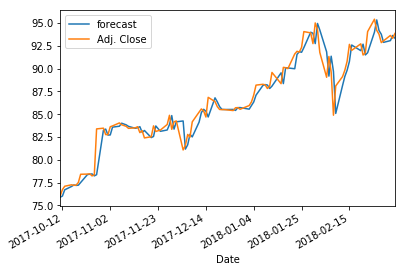

/Users/dtaieb/anaconda/envs/dashboard/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


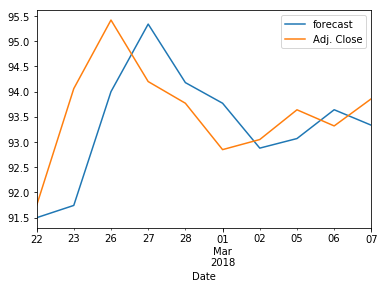

In [23]:
def plot_predict(model, dates_series, num_observations):
    fig = plt.figure(figsize = (12,5))
    model.plot_predict(
        start = str(dates_series[len(dates_series)-num_observations]), 
        end = str(dates_series[len(dates_series)-1])
    )
    plt.show()
    
plot_predict(arima_model, train_set['Date'], 100)
plot_predict(arima_model, train_set['Date'], 10)

## Diagnose the model against the test set values

In [19]:
def compute_test_set_predictions(train_set, test_set):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        history = train_set['Adj. Close'].values
        forecast = np.array([])
        for t in range(len(test_set)):
            prediction = ARIMA(history, order=(1,1,0)).fit(disp=0).forecast()
            history = np.append(history, test_set['Adj. Close'].iloc[t])
            forecast = np.append(forecast, prediction[0])
        return pd.DataFrame(
          {"forecast": forecast,
           "test": test_set['Adj. Close'],
           "Date": pd.date_range(start=test_set['Date'].iloc[len(test_set)-1], periods = len(test_set))
          }
        )
        
results = compute_test_set_predictions(train_set, test_set)
display(results)

## Compute the mean squared error of the predictions for the test set

In [246]:
from sklearn.metrics import mean_squared_error
def compute_mean_squared_error(test_series, forecast_series):
    return mean_squared_error(test_series, forecast_series)

print('Mean Squared Error: {}'.format( compute_mean_squared_error( test_set['Adj. Close'], forecast)) )

Mean Squared Error: 6.336538843075749


## Improve the version of the StockExplorer PixieApp to add forecasting with ARIMA
1. Enable the user to enter a list of Stock Tickers
2. Provide a menu for basic plotting: Price over time and Daily stock spread over time
3. Menu for displaying moving average with configurable lag
4. Menu for displaying ACF and PACF with configurable lag
5. Menu for time series forecasting with ARIMA

## Base PixieApp used as parent class for all the subapp associated with each menu

In [6]:
@PixieApp
class BaseSubApp():
    def setup(self):
        self.lag = 50

    def add_ticker_selection_markup(refresh_ids):
        def deco(fn):
            def wrap(self, *args, **kwargs):
                return """
<div class="row" style="text-align:center">
    <div class="btn-group btn-group-toggle" style="border-bottom:2px solid #eeeeee" data-toggle="buttons">
        {%for ticker, state in this.parent_pixieapp.tickers.items()%}
        <label class="btn btn-secondary {%if this.parent_pixieapp.active_ticker == ticker%}active{%endif%}"
            pd_refresh=\"""" + ",".join(refresh_ids) + """\" pd_script="self.set_active_ticker('{{ticker}}')">
            <input type="radio" {%if this.parent_pixieapp.active_ticker == ticker%}checked{%endif%}> 
                {{ticker}}
        </label>
        {%endfor%}
    </div>
</div>
                """ + fn(self, *args, **kwargs)
            return wrap
        return deco
    
    def set_active_ticker(self, ticker):
        self.parent_pixieapp.set_active_ticker(ticker)
    
    @route(widget="lag_slider")
    def slider_screen(self):
        return """
<div>
    <label class="field">Lag:<span id="slideval{{prefix}}">50</span></label>
    <i class="fa fa-info-circle" style="color:orange" data-toggle="pd-tooltip" 
        title="Selected lag used to compute moving average, ACF or PACF"></i>
    <div id="slider{{prefix}}" name="slider" data-min=30 data-max=300
        data-default=50 style="margin: 0 0.6em;">
    </div>
</div>
<script>
$("[id^=slider][id$={{prefix}}]").each(function() {
    var sliderElt = $(this)
    var min = sliderElt.data("min")
    var max = sliderElt.data("max")
    var val = sliderElt.data("default")
    sliderElt.slider({
        min: isNaN(min) ? 0 : min,
        max: isNaN(max) ? 100 : max,
        value: isNaN(val) ? 50 : val,
        change: function(evt, ui) {
            $("[id=slideval{{prefix}}]").text(ui.value); 
            pixiedust.sendEvent({type:'lagSlider',value:ui.value})
        },
        slide: function(evt, ui) {
            $("[id=slideval{{prefix}}]").text(ui.value);
        }
    });
})
</script>
        """

## Sub App for basic exploration of the selected Stock Time Serie

In [7]:
@PixieApp
class StockExploreSubApp(BaseSubApp):
    @route()
    @BaseSubApp.add_ticker_selection_markup(['chart{{prefix}}', 'daily_spread{{prefix}}'])
    def main_screen(self):
        return """
<div class="row" style="min-height:300px">
    <div class="col-xs-6" id="chart{{prefix}}" pd_render_onload pd_options="show_chart=Adj. Close">
    </div>
    <div class="col-xs-6" id="daily_spread{{prefix}}" pd_render_onload pd_options="show_chart=daily_spread">
    </div>
</div>
"""
        
    @route(show_chart="*")
    def show_chart_screen(self, show_chart):
        return """
<div pd_entity="parent_pixieapp.get_active_df()" pd_render_onload>
    <pd_options>
    {
      "handlerId": "lineChart",
      "valueFields": "{{show_chart}}",
      "rendererId": "bokeh",
      "keyFields": "Date",
      "noChartCache": "true",
      "rowCount": "10000"
    }
    </pd_options>
</div>
        """

## Sub App for displaying moving average of the selected Stock Time Serie

In [8]:
@PixieApp
class MovingAverageSubApp(BaseSubApp):
    @route()
    @BaseSubApp.add_ticker_selection_markup(['chart{{prefix}}'])
    def main_screen(self):
        return """
<div class="row" style="min-height:300px">
    <div class="page-header text-center">
        <h1>Moving Average for {{this.parent_pixieapp.active_ticker}}</h1>
    </div>
    <div class="col-sm-12" id="chart{{prefix}}" pd_render_onload pd_entity="get_moving_average_df()">
        <pd_options>
        {
          "valueFields": "Adj. Close",
          "keyFields": "x",
          "rendererId": "bokeh",
          "handlerId": "lineChart",
          "rowCount": "10000"
        }
        </pd_options>
    </div>
</div>
<div class="row">
    <div pd_widget="lag_slider">
        <pd_event_handler 
            pd_source="lagSlider"
            pd_script="self.lag = eventInfo['value']"
            pd_refresh="chart{{prefix}}">
        </pd_event_handler>
    </div>
</div>
"""
    def get_moving_average_df(self):
        ma = self.parent_pixieapp.get_active_df()['Adj. Close'].rolling(window=self.lag).mean()
        ma_df = pd.DataFrame(ma)
        ma_df["x"] = ma_df.index
        return ma_df

## Sub App for displaying ACF and PACF of the selected Stock Time Serie

In [9]:
import statsmodels.tsa.api as smt
@PixieApp
class AutoCorrelationSubApp(BaseSubApp):
    @route()
    @BaseSubApp.add_ticker_selection_markup(['chart_acf{{prefix}}', 'chart_pacf{{prefix}}'])
    def main_screen(self):
        return """
<div class="row" style="min-height:300px">
    <div class="col-sm-6">
        <div class="page-header text-center">
            <h1>Auto-correlation Function</h1>
        </div>
        <div id="chart_acf{{prefix}}" pd_render_onload pd_options="show_acf=true">
        </div>
    </div>
    <div class="col-sm-6">
        <div class="page-header text-center">
            <h1>Partial Auto-correlation Function</h1>
        </div>
        <div id="chart_pacf{{prefix}}" pd_render_onload pd_options="show_pacf=true">
        </div>
    </div>
</div> 

<div class="row">
    <div pd_widget="lag_slider">
        <pd_event_handler 
            pd_source="lagSlider"
            pd_script="self.lag = eventInfo['value']"
            pd_refresh="chart_acf{{prefix}},chart_pacf{{prefix}}">
        </pd_event_handler>
    </div>
</div>
"""
    @route(show_acf='*')
    @captureOutput
    def show_acf_screen(self):
        smt.graphics.plot_acf(self.parent_pixieapp.get_active_df()['Adj. Close'], lags=self.lag)
    
    @route(show_pacf='*')
    @captureOutput
    def show_pacf_screen(self):
        smt.graphics.plot_pacf(self.parent_pixieapp.get_active_df()['Adj. Close'], lags=self.lag)

/Users/dtaieb/anaconda/envs/dashboard/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Sub App for time series forecasting with ARIMA

In [31]:
from statsmodels.tsa.arima_model import ARIMA

@PixieApp
class ForecastArimaSubApp(BaseSubApp):
    def setup(self):
        self.entity_dataframe = self.parent_pixieapp.get_active_df().copy()
        self.differencing = False
        
    def set_active_ticker(self, ticker):
        BaseSubApp.set_active_ticker(self, ticker)
        self.setup()

    @route()
    @BaseSubApp.add_ticker_selection_markup([])
    def main_screen(self):
        return """
<div class="page-header text-center">
    <h2>1. Data Exploration to test for Stationarity
        <button class="btn btn-default" pd_script="self.toggle_differencing()" pd_refresh>
            {%if this.differencing%}Remove differencing{%else%}Add differencing{%endif%}
        </button>
        <button class="btn btn-default" pd_options="do_forecast=true">
            Continue to Forecast
        </button>
    </h2>
</div>

<div class="row" style="min-height:300px">
    <div class="col-sm-10" id="chart{{prefix}}" pd_render_onload pd_options="show_chart=Adj. Close">
    </div>
</div>

<div class="row" style="min-height:300px">
    <div class="col-sm-6">
        <div class="page-header text-center">
            <h3>Auto-correlation Function</h3>
        </div>
        <div id="chart_acf{{prefix}}" pd_render_onload pd_options="show_acf=true">
        </div>
    </div>
    <div class="col-sm-6">
        <div class="page-header text-center">
            <h3>Partial Auto-correlation Function</h3>
        </div>
        <div id="chart_pacf{{prefix}}" pd_render_onload pd_options="show_pacf=true">
        </div>
    </div>
</div>
        """
    @route(show_chart="*")
    def show_chart_screen(self, show_chart):
        return """
<h3><center>Time Series</center></h3>
<div pd_render_onload pd_entity="entity_dataframe">
    <pd_options>
    {
      "rowCount": "10000",
      "keyFields": "Date",
      "valueFields": "Adj. Close",
      "handlerId": "lineChart",
      "noChartCache": "true"
    }
    </pd_options>
</div>
"""

    @route(show_acf='*')
    @captureOutput
    def show_acf_screen(self):
        smt.graphics.plot_acf(self.entity_dataframe['Adj. Close'], lags=50)
    
    @route(show_pacf='*')
    @captureOutput
    def show_pacf_screen(self):
        smt.graphics.plot_pacf(self.entity_dataframe['Adj. Close'], lags=50)
        
    def toggle_differencing(self):
        if self.differencing:
            self.entity_dataframe = self.parent_pixieapp.get_active_df().copy()
            self.differencing = False
        else:
            log_df = np.log(self.entity_dataframe['Adj. Close'])
            log_df.index = self.entity_dataframe['Date']
            self.entity_dataframe = pd.DataFrame(log_df - log_df.shift()).reset_index()
            self.entity_dataframe.dropna(inplace=True)
            self.differencing = True
            
    @route(do_forecast="true")
    @BaseSubApp.add_ticker_selection_markup([])
    def do_forecast_screen(self):
        return """
<div class="page-header text-center">
    <h2>2. Build Arima model
        <button class="btn btn-default" pd_options="do_diagnose=true">
            Diagnose Model
        </button>
    </h2>
</div>
<div class="row" id="forecast{{prefix}}">
    <div style="font-weight:bold">Enter the p,d,q order for the ARIMA model you want to build</div>

    <div class="form-group" style="margin-left: 20px">
        <label class="control-label">Enter the p order for the AR model:</label>
        <input type="text" class="form-control" id="p_order{{prefix}}" value="1" style="width: 100px;margin-left:10px">

        <label class="control-label">Enter the d order for the Integrated step:</label>
        <input type="text" class="form-control" id="d_order{{prefix}}" value="1" style="width: 100px;margin-left:10px">

        <label class="control-label">Enter the q order for the MA model:</label>
        <input type="text" class="form-control" id="q_order{{prefix}}" value="1" style="width: 100px;margin-left:10px">
    </div>

    <center>
        <button class="btn btn-default" pd_target="forecast{{prefix}}"
            pd_options="p_order=$val(p_order{{prefix}});d_order=$val(p_order{{prefix}});q_order=$val(p_order{{prefix}})">
        Go
        </button>
    </center>
</div>
"""
    @route(p_order="*",d_order="*",q_order="*")
    @templateArgs
    def build_arima_model_screen(self, p_order, d_order, q_order):
        #Build the arima model
        self.train_set = self.parent_pixieapp.get_active_df()[:-14]
        self.test_set = self.parent_pixieapp.get_active_df()[-14:]
        self.arima_model = ARIMA(
            self.train_set['Adj. Close'], dates=self.train_set['Date'], 
            order=(int(p_order),int(d_order),int(q_order))
        ).fit(disp=0)
        self.residuals = self.arima_model.resid.describe().to_frame().reset_index()
        return """
<div class="page-header text-center">
    <h3>ARIMA Model succesfully created</h3>
<div>
<div class="row">
    <div class="col-sm-10 col-sm-offset-3">
        <div pd_render_onload pd_options="plot_predict=true">
        </div>
        <h3>Predicted values against the train set</h3>
    </div>
</div>
<div class="row">
    <div pd_render_onload pd_entity="residuals">
        <pd_options>
        {
          "handlerId": "tableView",
          "table_noschema": "true",
          "table_nosearch": "true",
          "table_nocount": "true"
        }
        </pd_options>
    </div>
    <h3><center>Residual errors statistics</center></h3> 
<div>
        """
    
    @route(plot_predict="true")
    @captureOutput
    def plot_predict(self):
        plot_predict(self.arima_model, self.train_set['Date'], 100)

    def compute_test_set_predictions(self):
        return compute_test_set_predictions(self.train_set, self.test_set)

    @route(do_diagnose="true")
    @BaseSubApp.add_ticker_selection_markup([])
    def do_diagnose_screen(self):
        return """
<div class="page-header text-center"><h2>3. Diagnose the model against the test set</h2></div>
<div class="row">
    <div class="col-sm-10 center" pd_render_onload pd_entity="compute_test_set_predictions()">
        <pd_options>
        {
          "keyFields": "Date",
          "valueFields": "forecast,test",
          "handlerId": "lineChart",
          "rendererId": "bokeh",
          "noChartCache": "true"          
        }
        </pd_options>
    </div>
</div>
"""




## Main class for the StockExplorer PixieApp

In [32]:
@PixieApp
class StockExplorer():
    @route()
    def main_screen(self):
        return """
<style>
    div.outer-wrapper {
        display: table;width:100%;height:300px;
    }
    div.inner-wrapper {
        display: table-cell;vertical-align: middle;height: 100%;width: 100%;
    }
</style>
<div class="outer-wrapper">
    <div class="inner-wrapper">
        <div class="col-sm-3"></div>
        <div class="input-group col-sm-6">
          <input id="stocks{{prefix}}" type="text" class="form-control" 
              value="MSFT,AMZN,IBM"
              placeholder="Enter a list of stocks separated by comma e.g MSFT,AMZN,IBM">
          <span class="input-group-btn">
            <button class="btn btn-default" type="button" pd_options="explore=true">
                <pd_script>
self.select_tickers('$val(stocks{{prefix}})'.split(','))
                </pd_script>
                Explore
            </button>
          </span>
        </div>
    </div>
</div>   
"""
    
    def select_tickers(self, tickers):
        self.tickers = {ticker.strip():{} for ticker in tickers}
        self.set_active_ticker(tickers[0].strip())
        
    def set_active_ticker(self, ticker):
        self.active_ticker = ticker
        if 'df' not in self.tickers[ticker]:
            self.tickers[ticker]['df'] = quandl.get('WIKI/{}'.format(ticker))
            self.tickers[ticker]['df']['daily_spread'] = self.tickers[ticker]['df']['Adj. Close'] - self.tickers[ticker]['df']['Adj. Open']
            self.tickers[ticker]['df'] = self.tickers[ticker]['df'].reset_index()
            
    def get_active_df(self):
        return self.tickers[self.active_ticker]['df']

    @route(explore="*")
    @templateArgs
    def stock_explore_screen(self):
        tabs = [("Explore","StockExploreSubApp"), ("Moving Average", "MovingAverageSubApp"),
                ("ACF and PACF", "AutoCorrelationSubApp"), ("Forecast with ARIMA", "ForecastArimaSubApp")]
        return """
<style>    
    .btn:active, .btn.active {
        background-color:aliceblue;
    }
</style>
<div class="page-header">
  <h1>Stock Explorer PixieApp</h1>
</div>
<div class="container-fluid">
    <div class="row">
        <div class="btn-group-vertical btn-group-toggle col-sm-2" data-toggle="buttons">
            {%for title, subapp in tabs%}
            <label class="btn btn-secondary {%if loop.first%}active{%endif%}"
                pd_options="show_analytic={{subapp}}"
                pd_target="analytic_screen{{prefix}}">
                <input type="radio" {%if loop.first%}checked{%endif%}> 
                    {{title}}
            </label>
            {%endfor%}
        </div>
        <div id="analytic_screen{{prefix}}" class="col-sm-10">
        </div>
    </div>
"""
    @route(show_analytic="*")
    def show_analytic_screen(self, show_analytic):
        return """
<div pd_app="{{show_analytic}}" pd_render_onload></div>
"""
    
app = StockExplorer()
app.run()